# Biostat M280 Homework 3

**Due Friday, May 25 @ 11:59PM**

## Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

### Answer to Q1(1)  

I used countlines to get the number of data points in each year (2003-2008).

In [2]:
# how many data points
println(countlines("2003.csv"))
println(countlines("2004.csv"))
println(countlines("2005.csv"))
println(countlines("2006.csv"))
println(countlines("2007.csv"))
println(countlines("2008.csv"))

6488541
7129271
7140597
7141923
7453216
7009729


### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

### Answer to Q1(2)  

If we use double precision for the design matrix and use '9E' and basd level, there will be `(22+4)` columns for 2003-2008. From the Q1(1), we have alreday known that there are `(6488541+7129271+7140597+7141923+7453216+7009729) = 42363277` observations in year 2003-2008. So the design matrix could take up about `42363277 * 26 * 8 bytes = 8.8 Gb` in memory, which can not be fitted into the memory of my laptop (8Gb memory).   

The following show an example to load data in 2003 into memory. 

In [1]:
# Pkg.add("JuliaDB")
# import data from csv
using JuliaDB

In [11]:
@time yrtable = loadtable(
    "2003.csv", 
    datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])

 36.232063 seconds (144.03 M allocations: 7.497 GiB, 36.01% gc time)


Table with 6488540 rows, 4 columns:
DepDelay  ArrDelay  UniqueCarrier  Distance
───────────────────────────────────────────
-4        -1        "UA"           837
-1        -3        "UA"           837
29        23        "UA"           837
-2        -9        "UA"           1835
18        52        "UA"           1835
-4        6         "UA"           1835
-4        -8        "UA"           1835
0         2         "UA"           1835
-4        19        "UA"           1835
3         4         "UA"           413
-4        -23       "UA"           413
-3        -19       "UA"           413
⋮
#NA       #NA       "DL"           1891
29        62        "DL"           581
39        66        "DL"           1891
26        27        "DL"           1678
114       134       "DL"           946
44        53        "DL"           813
16        47        "DL"           432
50        54        "DL"           432
-3        -5        "DL"           453
3         3         "DL"           689
-1     

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

### Answer to Q1(3)  

Though the design matrix cannot be fitted into the memory, Cholesky and Sweep methods could solved linear regression models based on the Gram matrix $\mathbf{X}^{T}\mathbf{X}$ , which can be dynamically updated with incoming data. They can handle huge $n$ , moderate $p$ data sets that cannot fit into memory. Here, I used Sweep method to solve linear regression model, since it could give standard errors and so on. 

In [2]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)
# a custom function to generate [X y] from data table
function generate_xy(tbl::NextTable)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        # yrtable[i][:UniqueCarrier] == "9E" && continue # base level
        tbl[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

Dict{Int64,String} with 26 entries:
  1  => "Intercept"
  2  => "Distance"
  16 => "MQ"
  11 => "EV"
  21 => "UA"
  7  => "B6"
  9  => "DH"
  25 => "YV"
  10 => "DL"
  26 => "Gain"
  19 => "OO"
  17 => "NW"
  8  => "CO"
  22 => "US"
  6  => "AS"
  24 => "XE"
  4  => "AA"
  3  => "DepDelay"
  5  => "AQ"
  20 => "TZ"
  23 => "WN"
  13 => "FL"
  14 => "HA"
  15 => "HP"
  12 => "F9"
  ⋮  => ⋮

In [4]:
using SweepOperator

In [5]:
n = 0
for i = 2003: 2008
    yrtable = loadtable(string(i, ".csv"), datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"]);
    # drop rows with missing values
    yrtable = dropna(yrtable)
    xy = generate_xy(yrtable)
    n = n + size(xy, 1)
    Gram .= Gram + xy' * xy
    # println(i)
end

In [14]:
p = 25
sweep!(Gram, 1:p)

26×26 Array{Float64,2}:
     -2.00254e-6   4.21792e-11  …   1.98347e-6    1.14033   
      3.00028e10  -9.38376e-14     -5.01596e-12   0.00164935
      3.69821e8    2.76146e11       1.16836e-10  -0.0118811 
      3.91626e6    4.19149e9       -1.97927e-6   -1.8723    
  88336.0          3.75197e7       -1.98134e-6   -0.5789    
 937547.0          8.30881e8    …  -1.98009e-6   -0.938452  
 799117.0          9.55599e8       -1.97878e-6   -1.42247   
      1.8094e6     2.03781e9       -1.97887e-6   -2.57627   
 669687.0          2.51484e8       -1.98271e-6    1.16808   
      3.37715e6    2.9514e9        -1.97993e-6   -2.19625   
      1.64509e6    7.42218e8    …  -1.98278e-6    1.03932   
 334842.0          2.97744e8       -1.97972e-6   -2.15207   
      1.24932e6    8.33171e8       -1.98132e-6   -1.35247   
 272859.0          1.61374e8       -1.98044e-6   -1.87248   
 574927.0          5.84803e8       -1.97917e-6   -0.350758  
      2.90986e6    1.13812e9    …  -1.98262e-6   -1.46395   


In [32]:
# estimated regression coefficients 
σ2 = Gram[p + 1, end] / (n - 1)
n

41490375

In [48]:
# Compute the standart errors of coefficients
β_var = -Diagonal(Gram[1:p, 1:p] * σ2);
β_se = sqrt.(β_var)
# se = sqrt.(se)

25×25 SparseMatrixCSC{Float64,Int64} with 25 stored entries:
  [1 ,  1]  =  0.0202318
  [2 ,  2]  =  4.37958e-6
  [3 ,  3]  =  6.88878e-5
  [4 ,  4]  =  0.0215571
  [5 ,  5]  =  0.0521477
  [6 ,  6]  =  0.0250361
  [7 ,  7]  =  0.0259154
  [8 ,  8]  =  0.0229534
  [9 ,  9]  =  0.0266552
  [10, 10]  =  0.021659
  ⋮
  [15, 15]  =  0.0276918
  [16, 16]  =  0.0218055
  [17, 17]  =  0.0220088
  [18, 18]  =  0.023446
  [19, 19]  =  0.0217463
  [20, 20]  =  0.0375073
  [21, 21]  =  0.0219444
  [22, 22]  =  0.0220022
  [23, 23]  =  0.0209201
  [24, 24]  =  0.0222383
  [25, 25]  =  0.0255715

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

## Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write down the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank-1 matrix.

### Answer to Q2(1)  


$
P_{ij} =  \begin{cases}
	\frac{1-p}{n} + {\frac{a_{ij}p}{r_{i}}} & \text{if $r_{i} \neq 0$} \\
	\frac{1}{n} & \text{otherwise}
	\end{cases}
$



### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

### Answer to Q2(2)  

$\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$, then we have $\mathbf{P}^T \mathbf{x} = \mathbf{x}$.  
So

$
 \mathbf{P}^T \mathbf{x} = \frac{1-p}{n}\mathbf{E}\mathbf{x} + p\mathbf{A}\mathbf{R}^{-1}\mathbf{x}
 = \mathbf{x}
$  

Then we can have the linear system solution.  

$
\mathbf{x}(\mathbf{I}-p\mathbf{A}\mathbf{R}^{-1})=\frac{1-p}{n}\mathbf{1}
$  

$\mathbf{1}$ is the column vectors of length $n$ containing only ones.



The problem of solving eigen-problem $\mathbf{P}^{T}\mathbf{x} = \mathbf{x}$ is equivalent to $(\mathbf{P}^T-\mathbf{I})\mathbf{x} = \mathbf{0}$ Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient, and we cannot use LU decomposition to solve it directly. In order to solve the problem, we can add another row to the original problem. 

$
\
\begin{bmatrix}
\mathbf{P_n}^{T} - \mathbf{I_n} \\
\mathbf{1}
\end{bmatrix}\mathbf{x}= 
\begin{bmatrix}
\mathbf{0_n}\\
\mathbf{1}
\end{bmatrix}
\
$  

So if we set $\mathbf{A} =
\begin{bmatrix}
\mathbf{P_n}^{T} - \mathbf{I_n} \\
\mathbf{1}
\end{bmatrix} $ and $\mathbf{b} = \begin{bmatrix}
\mathbf{0_n}\\
\mathbf{1}
\end{bmatrix}$, we can solve the linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$

### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

### Answer to Q2(3)  


In [1]:
# Pkg.add("CSV")
using CSV

In [76]:
# Load the data into Julia
data_u_loc = "U.txt"
data_a_loc = "A.txt"
U = CSV.read(data_u_loc, header=0);
A = Array(CSV.read(data_a_loc, header=0));
# Get the number of pages, which corresponds to the number of lines in U
println("The number of pages is ", size(U, 1))
println("The number of edges is ", sum(A))

The number of pages is 500
The number of edges is 11158


In [7]:
# Get the number of dangling nodes
n_dangling = 0
for row = 1:500
    if sum(A[row, :]) == 0
        n_dangling = n_dangling + 1
    end
end
println("The number of dangling nodes is ", n_dangling)

The number of dangling nodes is 96


In [8]:
# Keep record for maximum in-degree
max_in = 0
# Keep record for the index of page with maximum in-degree
max_in_index = 0
# Keep record for maximum out-degree
max_out = 0
# Keep record for the index of page with maximum out-degree
max_out_index = 0
for idx = 1:500
    out_degree = sum(A[idx, :])
    if out_degree > max_out
        max_out = out_degree
        max_out_index = idx
    end
    
    in_degree = sum(A[:, idx])
    if in_degree > max_in
        max_in = in_degree
        max_in_index = idx
    end
    
end
println("The page with maximum out degree ", max_out_index)
println(U[max_out_index, :])
println("The page with maximum in degree ", max_in_index)
println(U[max_in_index, :])

The page with maximum out degree 36
1×1 DataFrames.DataFrame
│ Row │ Column1                │
├─────┼────────────────────────┤
│ 1   │ http://giveto.ucla.edu │
The page with maximum in degree 1
1×1 DataFrames.DataFrame
│ Row │ Column1             │
├─────┼─────────────────────┤
│ 1   │ http://www.ucla.edu │


In [4]:
using PyPlot

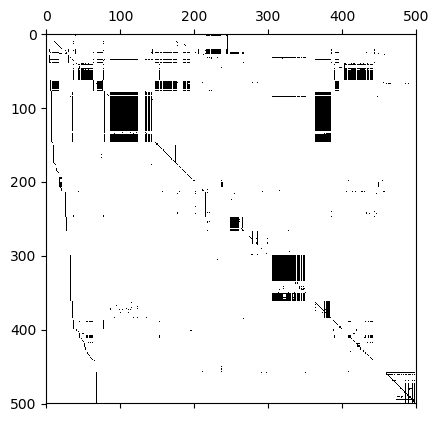

PyObject <matplotlib.image.AxesImage object at 0x11f51e690>

In [5]:
spy(full(A))

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (diagonal + rank 1) to speed up the matrix-vector multiplication.

In [115]:
typeof(sparse(A))

SparseMatrixCSC{Union{Int64, Missings.Missing},Int64}

In [118]:
# Pkg.add("IterativeSolvers")
using BenchmarkTools, IterativeSolvers

In [111]:
# Compute the P for dense linear solver
P = zeros(size(A, 1), size(A, 2))
tel_const = (1 - 0.85) / 500
for idx = 1: 500
    # compute all out degrees
    sum_out = sum(A[idx, :])
    if sum_out != 0
        for idy = 1: 500
            P[idx, idy] =  A[idx, idy] * 0.85 / sum_out + tel_const
        end
    else
        for idy = 1: 500
            P[idx, idy] = 1 / 500
        end
    end
end
# P = (sparse(P_sparse) + (1 / 500) * ones(500, 500))' - I
P = [P' - I; ones(1, 500)];
b = [zeros(500, 1); 1];

In [104]:
# Compute LU decomposition to solve linear function
P_lu = lufact(P);
x = P_lu[:L] \ (sparse(P_lu[:P]) * b)
x = P_lu[:U] \ x

500×1 Array{Float64,2}:
 0.0115263 
 0.00118521
 0.00368196
 0.00361842
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00118521
 0.00137118
 0.00133263
 ⋮         
 0.00136037
 0.00136037
 0.00129072
 0.00337188
 0.00215239
 0.00136037
 0.00136037
 0.00750605
 0.00136037
 0.00136037
 0.00136037
 0.00107129

In [142]:
# Construct P in terms of a sparse matrix plus a rank 1 matrix
P_sparse = zeros(size(A, 1), size(A, 2))
for idx = 1: 500
    # compute all out degrees
    sum_out = sum(A[idx, :])
    if sum_out != 0
        for idy = 1: 500
            P_sparse[idx, idy] =  A[idx, idy] * 0.85 / sum_out - 0.85 / 500
        end
    end
end
P_sparse = sparse(P_sparse') + (1 / 500) * ones(500, 500) - I;

In [144]:
# Use Gauss-Seidel solver
x_init = rand(500, 1)
gauss_seidel!(x_init, P_sparse, b)
# Normalize vectors
x = x_init / sum(x_init)

500×1 Array{Float64,2}:
 0.0115295 
 0.00118531
 0.00368274
 0.00361918
 0.0011853 
 0.0011853 
 0.0011853 
 0.0011853 
 0.0011853 
 0.0011853 
 0.0011853 
 0.00137131
 0.00133274
 ⋮         
 0.00136004
 0.00136002
 0.00129038
 0.0033713 
 0.00215196
 0.00136002
 0.00136002
 0.00750451
 0.00135992
 0.0013599 
 0.0013599 
 0.00107092

In [145]:
sum(x)

1.0

In [133]:
r

0.0

In [157]:
vecnorm(xjacobi - xlu)

0.008769447566233898

In [198]:
# Compute the initial P: AR^-1
P = zeros(size(A, 1), size(A, 2))
for idx = 1: 500
    # compute all out degrees
    sum_out = sum(A[idx, :])
    if sum_out != 0
        for idy = 1: 500
            P[idx, idy] =  A[idx, idy] / sum_out
        end
    end
end
P = 0.85 * P + ((1 - 0.85) / 500) * ones(500, 500);

In [181]:
sum(P[:,1])

7.332230778389986

In [199]:
Peig = eigfact(P')
Peig[:values]

500-element Array{Complex{Float64},1}:
     0.868175+0.0im        
     0.791253+0.0im        
         0.85+0.0im        
      0.69769+0.0im        
     0.651704+0.0im        
    -0.282878+0.0im        
     0.612784+0.0im        
     0.580663+0.0im        
     0.570039+0.0im        
    -0.242323+0.0im        
     0.485625+0.0im        
     0.466323+0.0im        
    -0.184508+0.0im        
             ⋮             
 -2.60557e-22+2.78598e-21im
 -2.60557e-22-2.78598e-21im
  1.56019e-21+0.0im        
 -1.20468e-21+9.96322e-22im
 -1.20468e-21-9.96322e-22im
  1.65178e-22+4.40405e-22im
  1.65178e-22-4.40405e-22im
 -3.45305e-23+0.0im        
  1.05241e-23+0.0im        
 -1.90856e-24+0.0im        
  -4.1049e-30+0.0im        
 -3.64697e-13+0.0im        

### Q2(5)

List the top 20 ranked URLs you found.

### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.